In [2]:
%pylab inline
import seaborn as s

Populating the interactive namespace from numpy and matplotlib


In [11]:
def region(*args):
    x,y = args
    return (x > 0) & (y >= 0) & ( (4 * x + y < 100) | (x + 4 * y < 100) )

In [17]:
def region(*args):
    x,y = args
    return (x > 0) & (y >= 0) & (x < 110) & (y < 110) & ( (x + y < 100) | (x + y > 120) )

In [15]:
def region(*args):
    x,y = args
    return (x > 0) & (y >= 0) & (x < 110) & (y < 110) & \
      ( (x + y < 100) | (x + y > 120) ) & \
      ( (x - y > 10 ) | (x - y < -10) ) & \
      ( (x < 54 ) | (x > 56) ) & \
      ( (y < 54 ) | (y > 56) ) 

(-50.0, 150.0)

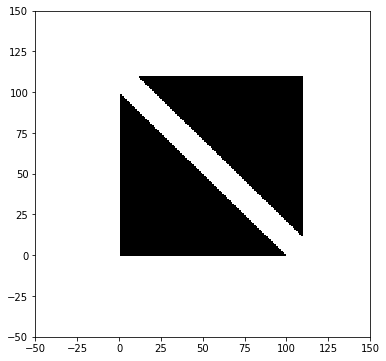

In [18]:
figsize(6,6)
x , y = np.meshgrid(np.linspace(-50,150,201),np.linspace(-50,150,201))
pcolormesh(x,y, region(x,y), cmap='Greys')
xlim()

In [19]:
import tensorflow as tf

In [20]:
def smooth_max(alpha):
    if alpha <= 0:
        raise ValueError("alpha must be positive")
    def f(x,y):
        delta = alpha * (x - y)
        return tf.where( delta > 0,
            (x + tf.exp(-delta) * y) / (1 + tf.exp(-delta)),
            (y + tf.exp( delta) * x) / (1 + tf.exp( delta))
        )
    return f

def smooth_min(alpha):
    if alpha <= 0:
        raise ValueError("alpha must be positive")
    def f(x,y):
        delta = alpha * (x - y)
        return tf.where( delta > 0,
            (y + tf.exp(-delta) * x) / (1 + tf.exp(-delta)),
            (x + tf.exp( delta) * y) / (1 + tf.exp( delta))
        )
    return f

In [22]:
class TfBoolSymb(object):
    def __init__(self, tensor, alpha):
        self.tensor = tensor
        self.alpha = alpha
    def __and__(self, other):
        x , y = self.tensor, other.tensor
        return TfBoolSymb(smooth_min(self.alpha)(x,y), self.alpha)
    def __or__(self, other):
        x , y = self.tensor, other.tensor
        return TfBoolSymb(smooth_max(self.alpha)(x,y), self.alpha)
    
    
class TfIntSymb(object):
    def __init__(self, tensor, beta, alpha = 10.0):
        self.tensor = tensor
        self.alpha = alpha
        self.beta = beta
    def __lt__(self, other):
        d = tf.sigmoid( self.beta * (other - self.tensor + 0.5) )
        return TfBoolSymb(d, self.alpha)
    def __le__(self, other):
        d = tf.sigmoid( self.beta * (other - self.tensor - 0.5) )
        return TfBoolSymb(d, self.alpha)
    def __eq__(self, other):
        x = tf.sigmoid( self.beta * (self.tensor - other - 0.5) )
        y = tf.sigmoid( self.beta * (other - self.tensor + 0.5) )
        return TfBoolSymb(smooth_min(self.alpha)(x,y), self.alpha)
    def __ne__(self, other):
        x = tf.sigmoid( self.beta * (self.tensor - other - 0.5) )
        y = tf.sigmoid( self.beta * (other - self.tensor + 0.5) )
        return TfBoolSymb(1 - smooth_min(self.alpha)(x,y), self.alpha)
    def __gt__(self, other):
        d = tf.sigmoid( self.beta * (self.tensor - other - 0.5) )
        return TfBoolSymb(d, self.alpha)        
    def __ge__(self, other):
        d = tf.sigmoid( self.beta * (self.tensor - other + 0.5) )
        return TfBoolSymb(d, self.alpha)        
    
    def __op(self, other, f):
        if isinstance(other, TfIntSymb):
            other = other.tensor
        return TfIntSymb(f(self.tensor, other), self.beta, alpha)
    def __add__(self, other):
        return self.__op(other, lambda x,y: x + y)
    def __radd__(self, other):
        return self.__op(other, lambda x,y: y + x)
    def __sub__(self, other):
        return self.__op(other, lambda x,y: x - y)
    def __rsub__(self, other):
        return self.__op(other, lambda x,y: y - x)
    def __mul__(self, other):
        return self.__op(other, lambda x,y: x * y)
    def __rmul__(self, other):
        return self.__op(other, lambda x,y: y * x)    
    

In [35]:
alpha, beta = 3.0, 0.2
x = tf.placeholder(tf.float32, shape=(101,101))
y = tf.placeholder(tf.float32, shape=(101,101))
sx = TfIntSymb(x, beta, alpha)
sy = TfIntSymb(y, beta, alpha)
sr = region(sx,sy)

In [36]:
sr

In [37]:
fx , fy = np.meshgrid(np.linspace(-50,150,101),np.linspace(-50,150,101))
with tf.Session() as sess:
    fr = sess.run(sr.tensor, feed_dict={x:fx, y:fy})

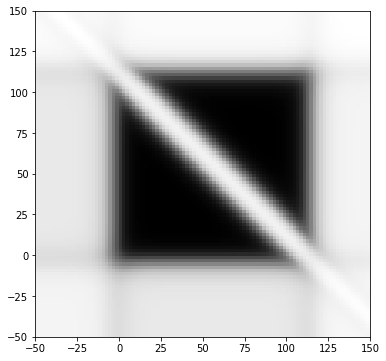

In [38]:
figsize(6,6)
pcolormesh(fx,fy,fr, cmap='Greys')

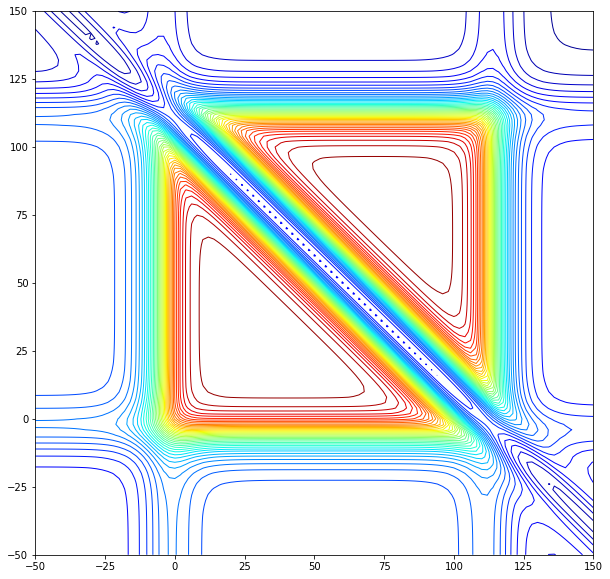

In [39]:
figsize(10,10)
contour(fx,fy,fr,50, cmap='jet', linewidths=1)

In [40]:
gradx, grady = tf.gradients(sr.tensor, [x,y])
with tf.Session() as sess:
    gx,gy = sess.run([gradx,grady], feed_dict={x:fx, y:fy})

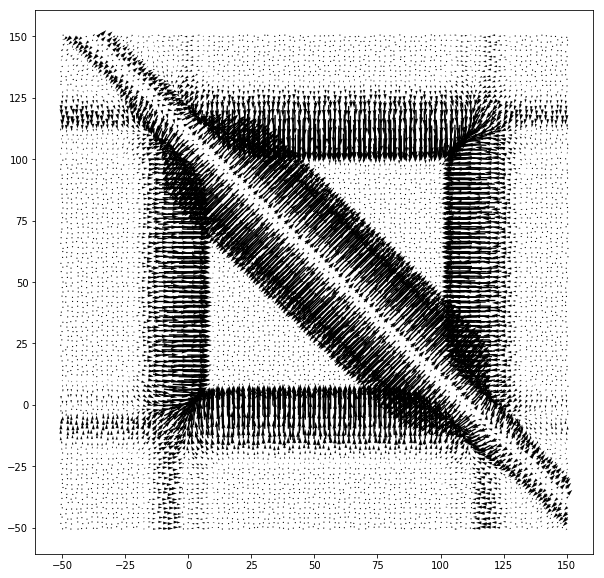

In [41]:
figsize(10,10)
#contour(fx,fy,fr,50, colors='k', linewidths=1, alpha=0.3)
sfx = fx + np.random.rand(*fx.shape) - 0.5
sfy = fy + np.random.rand(*fy.shape) - 0.5
quiver(sfx,sfy,gx,gy, scale=1)

In [ ]:
np.random.rand(*fx.shape)/2.0

# Explanations

## Basic idea

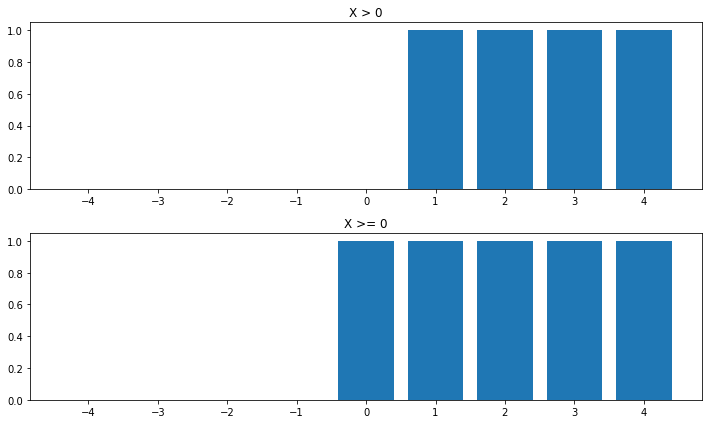

In [3]:
figsize(10,6)
subplot(211)
x = np.arange(-4,5)
bar(x, x > 0)
title("X > 0")
xticks(x);
subplot(212)
bar(x, x >= 0)
title("X >= 0")
xticks(x);
tight_layout()

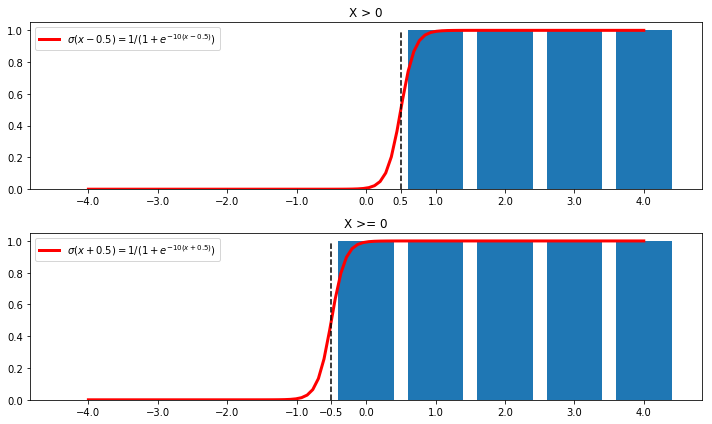

In [4]:
figsize(10,6)
subplot(211)
x = np.arange(-4,5)
bar(x, x > 0)
xticks(list(x) + [0.5]);

x = np.linspace(-4,4,100)
plot(x, 1 / (1 + np.exp(-10.*(x-0.5))), 'r', label = "$\sigma(x-0.5) = 1/(1+e^{-10(x-0.5)})$",lw=3)
plot([0.5,0.5],[0.0,1.0], 'k--')

title("X > 0");
legend()

subplot(212)
x = np.arange(-4,5)
bar(x, x >= 0)
xticks(list(x) + [-0.5]);

x = np.linspace(-4,4,100)
plot(x, 1 / (1 + np.exp(-10.*(x+0.5))), 'r', label = "$\sigma(x+0.5) = 1/(1+e^{-10(x+0.5)})$",lw=3)
plot([-0.5,-0.5],[0.0,1.0], 'k--')

title("X >= 0");
legend()
tight_layout()

## Smoothing $\beta$ parameter

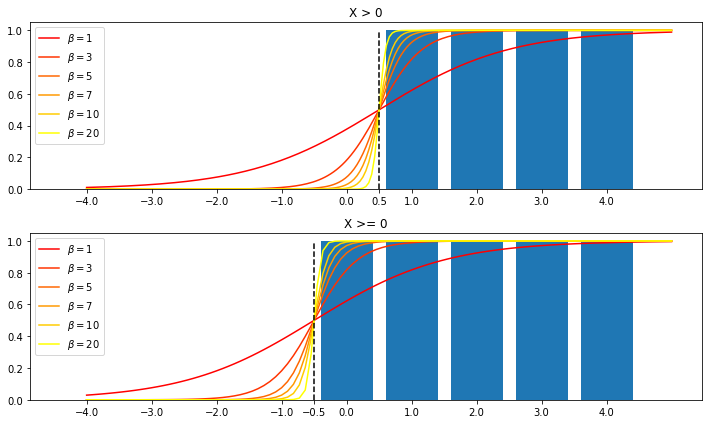

In [5]:
figsize(10,6)
subplot(211)
x = np.arange(-4,5)
bar(x, x > 0)
xticks(list(x) + [0.5]);

x = np.linspace(-4,5,200)
for n,beta in enumerate([1,3,5,7,10,20]):
    plot(x, 1 / (1 + np.exp(-beta*(x-0.5))), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))
plot([0.5,0.5],[0.0,1.0], 'k--')

title("X > 0");
legend()

subplot(212)
x = np.arange(-4,5)
bar(x, x >= 0)
xticks(list(x) + [-0.5]);

x = np.linspace(-4,5,100)
for n,beta in enumerate([1,3,5,7,10,20]):
    plot(x, 1 / (1 + np.exp(-beta*(x+0.5))), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))
plot([-0.5,-0.5],[0.0,1.0], 'k--')

title("X >= 0");
legend()
tight_layout()

## Logical operation

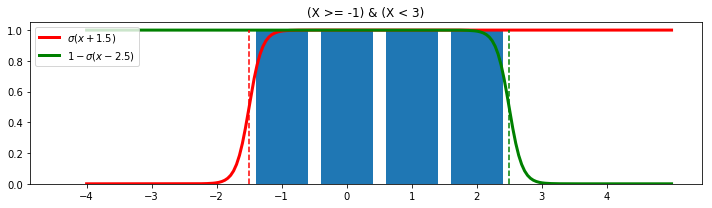

In [6]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x >= -1) & (x < 3))
title("(X >= -1) & (X < 3)")
xticks(x);

x = np.linspace(-4,5,200)
plot(x, 1 / (1 + np.exp(-10.*(x+1.5))), 'r', label = "$\sigma(x+1.5)$",lw=3)
plot(x, 1 - 1 / (1 + np.exp(-10.*(x-2.5))), 'g', label = "$1-\sigma(x-2.5)$",lw=3)
plot([-1.5,-1.5],[0,1], 'r--')
plot([ 2.5, 2.5],[0,1], 'g--')
legend(loc=2)

tight_layout()

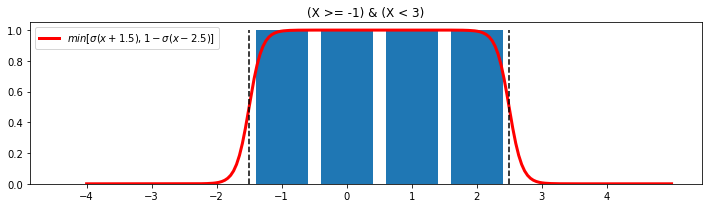

In [7]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x >= -1) & (x < 3))
title("(X >= -1) & (X < 3)")
xticks(x);

x = np.linspace(-4,5,200)
s1 = 1 / (1 + np.exp(-10.*(x+1.5)))
s2 = 1 - 1 / (1 + np.exp(-10.*(x-2.5)))
plot(x, np.minimum(s1,s2), 'r', label = "$min\left[\sigma(x+1.5), 1-\sigma(x-2.5)\\right]$",lw=3)
plot([-1.5,-1.5],[0,1], 'k--')
plot([ 2.5, 2.5],[0,1], 'k--')
legend(loc=2)

tight_layout()

## Smooth miniimum

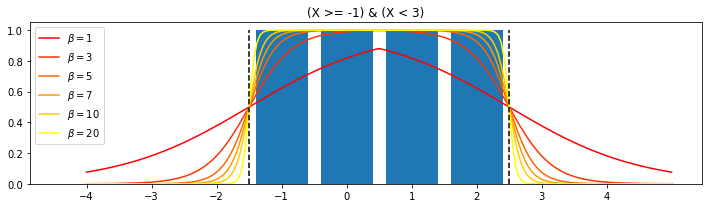

In [8]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x >= -1) & (x < 3))
title("(X >= -1) & (X < 3)")
xticks(x);

x = np.linspace(-4,5,200)
for n,beta in enumerate([1,3,5,7,10,20]):
    s1 = 1 / (1 + np.exp(-beta*(x+1.5)))
    s2 = 1 - 1 / (1 + np.exp(-beta*(x-2.5)))
    plot(x, np.minimum(s1,s2), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))

plot([-1.5,-1.5],[0,1], 'k--')
plot([ 2.5, 2.5],[0,1], 'k--')
legend(loc=2)

tight_layout()

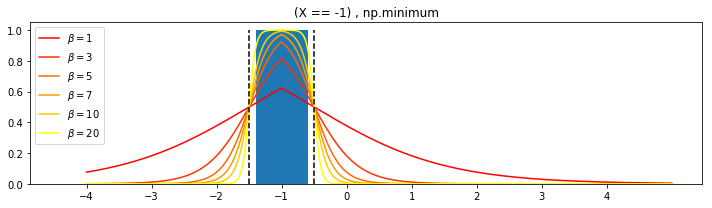

In [9]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x == -1) )
title("(X == -1) , np.minimum")
xticks(x);

x = np.linspace(-4,5,400)
for n,beta in enumerate([1,3,5,7,10,20]):
    s1 = 1 / (1 + np.exp(-beta*(x+1.5)))
    s2 = 1 - 1 / (1 + np.exp(-beta*(x+0.5)))
    plot(x, np.minimum(s1,s2), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))

plot([-1.5,-1.5],[0,1], 'k--')
plot([-0.5,-0.5],[0,1], 'k--')
legend(loc=2)
tight_layout()

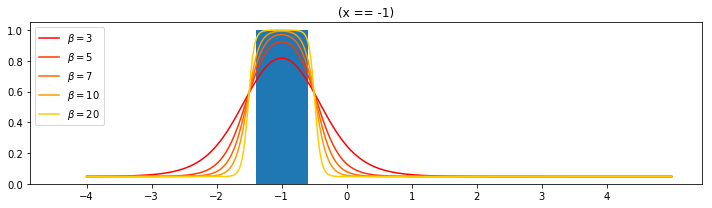

In [49]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x == -1)  )
title("(x == -1)")
xticks(x);

def soft_minimum(a,b, alpha=3.0):
    ea, eb = np.exp(-alpha*a), np.exp(-alpha*b) 
    return (a * ea + b * eb) / (ea + eb) 

x = np.linspace(-4,5,400)
for n,beta in enumerate([3,5,7,10,20]):
    s1 = 1 / (1 + np.exp(-beta*(x+1.5)))
    s2 = 1 - 1 / (1 + np.exp(-beta*(x+0.5)))
    
    plot(x, soft_minimum(s1,s2), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))

legend(loc=2)

tight_layout()

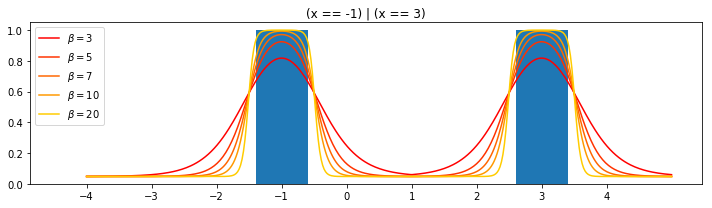

In [50]:
figsize(10,3)
x = np.arange(-4,5)
bar(x, (x == -1) | (x == 3) )
title("(x == -1) | (x == 3)")
xticks(x);

def soft_minimum(a,b, alpha=3.0):
    ea, eb = np.exp(-alpha*a), np.exp(-alpha*b) 
    return (a * ea + b * eb) / (ea + eb) 

def soft_maximum(a,b, alpha=3.0):
    ea, eb = np.exp(-alpha*a), np.exp(-alpha*b) 
    return (a * ea + b * eb) / (ea + eb) 


x = np.linspace(-4,5,400)
for n,beta in enumerate([3,5,7,10,20]):
    s1 = 1 / (1 + np.exp(-beta*(x+1.5)))
    s2 = 1 - 1 / (1 + np.exp(-beta*(x+0.5)))
    s3 = 1 / (1 + np.exp(-beta*(x-2.5)))
    s4 = 1 - 1 / (1 + np.exp(-beta*(x-3.5)))
    
    plot(x, np.maximum(soft_minimum(s1,s2),soft_minimum(s3,s4)), label = "$\\beta = {}$".format(beta), color=cm.autumn(n/5.0))

legend(loc=2)

tight_layout()